## Association Rules

The objective of this kernel is to do an association rule algorithms Apriori to find correlations between different items. With associacion rule learning, recommendation systems can be made as well as strategies of product placement in stores.

The algorithm is bases on a simple statement: 'If someone does/buys/watches this, that person might do/buy/watch this other thing'

**Importing packages and modules**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth 
from PIL import Image
sns.set()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

/kaggle/input/hamb1png/Hamb1.png
/kaggle/input/market-basket-optimization/Market_Basket_Optimisation.csv


**Loading and getting to know the dataset**

In [2]:
dataset = pd.read_csv('../input/market-basket-optimization/Market_Basket_Optimisation.csv', header = None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
dataset.shape

(7501, 20)

In [4]:
dataset.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,antioxydant juice,frozen smoothie,protein bar,cereals,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


The dataset has 7501 rows, that represent each customer in a store. I'll do some visualizations to have a better idea of what are the most popular products.

We have to take into account that we don't know the time of the year or the hour of this transactions. It is expected that in summer people tend to buy more water and fruit for example.

**Visualizations**

The analysis will be made on the first column, as it has the most number of rows.

In [5]:
mask = np.array(Image.open('../input/hamb1png/Hamb1.png'))

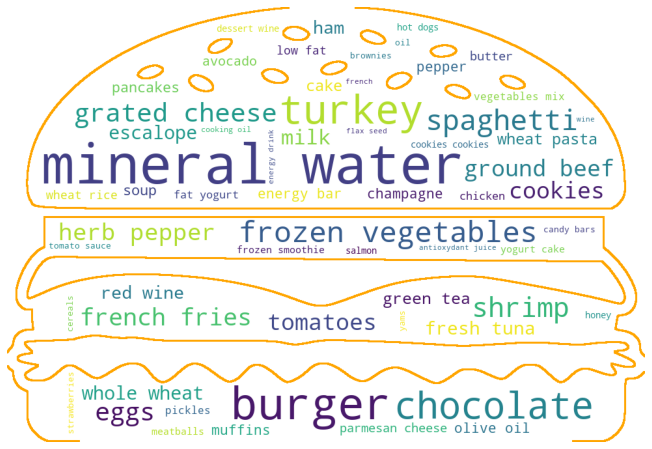

In [6]:
plt.subplots(figsize=(12,8))
wordcloud = WordCloud(
                          background_color='White',max_words = 60,
                          mask = mask, contour_color='orange', contour_width=4, 
                          width=1500, margin=10,
                          height=1080
                         ).generate(" ".join(dataset[0]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

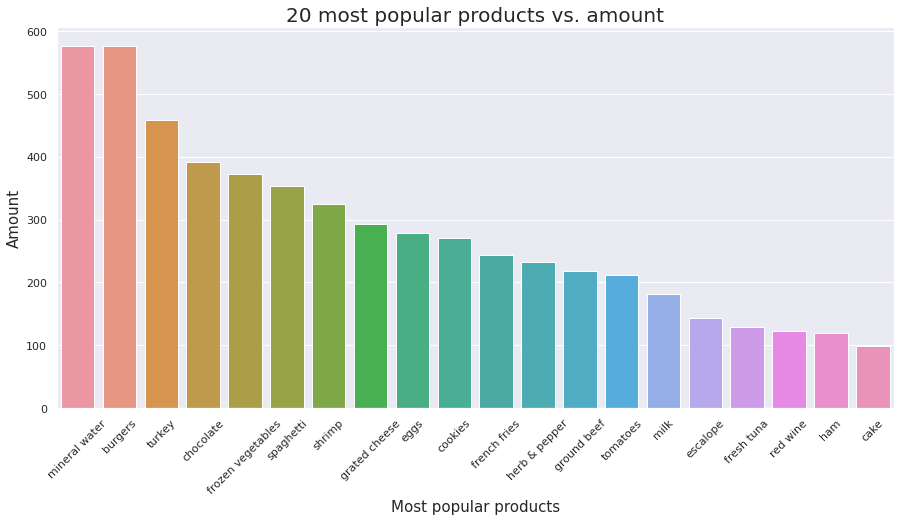

In [7]:
Products = pd.DataFrame(dataset[0].value_counts())
Twenty_Products = pd.DataFrame(dataset[0].value_counts()).head(20)

sns.barplot(x = Twenty_Products.index, y = Twenty_Products[0])

labels =Twenty_Products.index.tolist()
plt.gcf().set_size_inches(15, 7)

plt.title('20 most popular products vs. amount', fontsize = 20)
plt.xlabel('Most popular products', fontsize = 15)
plt.ylabel('Amount', fontsize = 15)

plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19] , labels = labels, rotation = '45')
plt.show()

In [8]:
Twenty_Products.columns = ['Amount']
Twenty_Products.head(10).style.background_gradient(cmap='plasma')

,Amount
mineral water,577
burgers,576
turkey,458
chocolate,391
frozen vegetables,373
spaghetti,354
shrimp,325
grated cheese,293
eggs,279
cookies,270


In [9]:
Twenty_Products["Item"] = Twenty_Products.index
Twenty_Products["20 most popular items"] = "20 most popular items"
Twenty_Products['index'] = list(range(len(Twenty_Products)))
Twenty_Products.set_index('index')
Twenty_Products = Twenty_Products[['Item','Amount',"20 most popular items"]]

In [10]:
fig = px.treemap(Twenty_Products, path=["20 most popular items", 'Item'], values='Amount',
                  color=Twenty_Products["Amount"], hover_data=['Item'],
                  color_continuous_scale='plasma',
                  )
fig.show()

## Apriori

Apriori uses three principal concepts:
- Support: probability of some action/item in the dataset.
- Confidence: How sure am I that two things are happening consequently?
- Lift: Confidence / Support. It's a measure to illustrate how likely is the second action to happen given the first action. 

In this case I'll work using only the support score.

I'll define as 'tickets' each row of the dataset, so I'll generate an array with every ticket.

In [11]:
tickets = []
for i in range(dataset.shape[0]):
    tickets.append([str(dataset.values[i,j]) for j in range(dataset.shape[1])])
    
tickets = np.array(tickets)

In [12]:
TE = TransactionEncoder()
dataset2 = TE.fit_transform(tickets)
dataset2 = pd.DataFrame(dataset2, columns = TE.columns_)

In [13]:
dataset2.head(3)

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now I have a dataframe with every single product and True or False values wheter they were or not bought in that ticket.

I'll use only the 20 most popular products.

In [14]:
dataset_20 = dataset2.copy()
dataset_20 = dataset_20[Twenty_Products["Item"]] # Using the previous DF.

I'll change the False to 0 , True to 1

In [15]:
def encode_units(x):
    if x == False:
        return 0 
    if x == True:
        return 1

In [16]:
dataset_20 = dataset_20.applymap(encode_units) # Element wise function in DF.
dataset_20.head(3)

,mineral water,burgers,turkey,chocolate,frozen vegetables,spaghetti,shrimp,grated cheese,eggs,cookies,french fries,herb & pepper,ground beef,tomatoes,milk,escalope,fresh tuna,red wine,ham,cake
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Model**

In [17]:
frequent_itemsets = apriori(dataset_20, min_support = 0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.238368,(mineral water),1
1,0.087188,(burgers),1
2,0.062525,(turkey),1
3,0.163845,(chocolate),1
4,0.095321,(frozen vegetables),1
...,...,...,...
116,0.010132,"(eggs, ground beef, mineral water)",3
117,0.013065,"(eggs, milk, mineral water)",3
118,0.011065,"(ground beef, mineral water, milk)",3
119,0.010532,"(eggs, spaghetti, chocolate)",3


As I'm interested in itemset with 2 or more items, I'll filter this.

Also, I'd like highest support scores.

**We could increase the support score to filter more and more itemsets, but if I want to come up with a comercial strategy I'll try to offer some discounts on itemsets**

In [18]:
frequent_itemsets[ (frequent_itemsets['length'] >= 2) &
                   (frequent_itemsets['support'] >= 0.04) ]

,support,itemsets,length
22,0.052660,"(mineral water, chocolate)",2
24,0.059725,"(spaghetti, mineral water)",2
27,0.050927,"(eggs, mineral water)",2
30,0.040928,"(ground beef, mineral water)",2
32,0.047994,"(milk, mineral water)",2


We will keep these 5 itemsets.

What about a set of 3 items?

In [19]:
frequent_itemsets[ (frequent_itemsets['length'] == 3)].head(3)

,support,itemsets,length
106,0.015865,"(spaghetti, mineral water, chocolate)",3
107,0.013465,"(eggs, mineral water, chocolate)",3
108,0.010932,"(ground beef, mineral water, chocolate)",3


Thanks for reaching the end!! Upvote if you liked it!